#### Note:
1. Before running the notebook, please make sure to have the following libraries installed
- numpy
- pandas
- pytorch
- wandb
- matplotlib
<br>
In case, any library is missed here, you would be prompted with an ImportError. In such case, just install it with pip (google -> pip install library_name)

In [1]:
import random
import pandas as pd
import numpy as np
from tqdm import trange
import os
import datetime
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import optim

from utils import Utils
from encoder_decoder import seq2seq

import warnings
warnings.filterwarnings('ignore')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: aneog. Use `wandb login --relogin` to force relogin


## 0. GPU Selection
Check if GPU is available on the machine the notebook is running. If yes, then assign a GPU, else run it on CPU

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda:7')
else:
    device = torch.device('cpu')

## 1. Parameter setting

#### Specify the wandb project and wandb run
wandb refers to Weights and Biases. Integrating this tool into the notebook will allow it to access the run details and generate train and test curves, among many other information

In [3]:
# wandb project name
wandb_project = "lake_modeling"

# wandb run name
wandb_run = "test_run_{}_{}".format(str(datetime.datetime.now().date()), str(datetime.datetime.now().time()))

# Yes if we want wandb to save our python code, else no
save_code = True

#### Specify the input path (where the dataset is stored) and dataset name
Note: For different dataset, the processing/handling can/will be different. In this notebook, the original FCR (observational) data has been considered. It also has a metadata file
that stores the column names and types. In case of, say, the transfer learning data, there isn't any separate metadata file, plus it has multiple lakes. 
<br>
For the purpose of the tutorial, the notebook is kept simple, hence, going with FCR data for now

In [4]:
# Input path
path = '../'

# Name of the file
file = 'LSTM_dataset_07OCT22.csv'

# Name of the metadata file
metadata = 'LSTM_dataset_column_key_07OCT22.csv'

#### Specify the Time-series specific parameters

In [5]:
# Lookback window
input_window = 14

# horizon window
output_window = 14

# stride - While creating samples (lookback window + horizon window = 1 sample) define the amount of stride the sliding window needs to take
stride = 1

# The ratio in which train and test data is split. If it is 0.8, then first 80% of data goes into train and remaining 20% into test
split_ratio = 0.6

#### Specify the model specific parameters

In [6]:
# Types of Model include: LSTM, GRU, RNN
model_type = "LSTM"

# Number of layers in our deep learning model
num_layers = 1

# Hidden cell (RNN/LSTM/GRU) size
hidden_feature_size = 16

# Output size of our encoder_decoder model, i.e. number of target variables
output_size = 1

'''
Model Training parameters
'''
# batch_size during training
batch_size = 32

# Number of epochs we want to train the model for (1 epoch = 1 pass of the complete training data through the model)
epochs = 200

# Learning rate specifies the rate at which we want to update the model parameters after every training pass
learning_rate = 0.001

# Eval freq says how frequently during training do you want to evaluate your model on the validation data (to see its performance on non-training data)
eval_freq = 10 # logic is -> if iteration_num % eval_freq == 0 -> then perform evaluation

# While generating the training batches do we want the generator to shuffle the batches?
batch_shuffle = True

# Dropout is a form of regularization
dropout = 0.02

'''
Learning rate scheduler parameters
'''
max_lr=5e-4
div_factor=100
pct_start=0.05 
anneal_strategy='cos'
final_div_factor=10000.0

'''
Parameters for early stopping
'''
# Set to True if we want Early stopping
early_stop = False

# If there is no improvement for a 'thres' number of epocs stop the training process
thres=5

# Quantifying the improvement. If the validation loss is greater than min_val_loss_so_far + delta for thres number of iterations stop the training
delta=0.5

'''
Other parameters
'''
# Specify the amount of L2 regularization to be applied.
weight_decay=0.05

# Specify the percentage of times we want to enforce teacher forcing
teacher_forcing_ratio = 0.0
training_prediction = 'recursive'

## 2. Data Processing

#### Read the metadata file

In [7]:
dx = pd.read_csv(os.path.join(path, metadata))

# Extract all col names from Metadata
feature_cols = dx[dx['column_type']=='feature']['column_names'].tolist()  # feature colums represent the input drivers
target_cols = dx[dx['column_type']=='target']['column_names'].tolist()   # target column represent the chlorophyll values
date_col = dx[dx['column_type']=='date']['column_names'].tolist()[0]    # date column stores the date timeline

In [8]:
# Specify whether we want to add chlorophyll to the input feature set
feature_cols += target_cols
feature_cols

['daily_median_airtemp_interp_degC',
 'daily_median_swr_interp_Wm2',
 'daily_median_inflow_interp_cms',
 'daily_median_watertemp_interp_degC',
 'daily_median_srp_interp_ugL',
 'daily_median_din_interp_ugL',
 'daily_median_inflow_srp_interp_ugL',
 'daily_median_inflow_din_interp_ugL',
 'daily_median_Secchi_interp_m',
 'daily_median_CTD_Temp_C',
 'daily_median_GreenAlgae_ugL',
 'daily_median_Bluegreens_ugL',
 'daily_median_BrownAlgae_ugL',
 'daily_median_TotalConcNoMixed_ugL',
 'daily_median_chla_interp_ugL']

In [9]:
target_cols

['daily_median_chla_interp_ugL']

#### Create an utility object
An object of the Utils class, it contains all the utility functions like splitting train and test data, normalizing the data, etc.

In [10]:
'''
Utility instance - to perform data processing, train test split
'''
utils = Utils(num_features=len(feature_cols), inp_cols=feature_cols, target_cols=target_cols, date_col=date_col,
              input_window=input_window, output_window=output_window, num_out_features=output_size, stride=stride)

#### Read the dataset

In [11]:
'''
Read data
'''
df = pd.read_csv(path+file)

#### Train Test split
Ideally, a 3-way split is done - train, val and test. The validation split is generally used to tune the hyper-parameters during training. Once the hyper-parameters are tuned, the model
is re-trained on the train+val data. To keep the notebook short and simple, hyper-parameter tuning is not included

In [12]:
'''
Split data into train and test
'''
df_train, df_test = utils.train_test_split(df, split_ratio=split_ratio)

#### Normalize the data
Standard normalization - 0 mean and 1 standard deviation

In [13]:
'''
Data Scaling
'''
df_train = utils.normalize(df_train)

In [14]:
df_test = utils.normalize(df_test, use_stat=True)

#### Create train and test samples
Each sample is created using a sliding window. 1 sliding window = 1 lookback window + 1 horizon window = 1 sample

In [15]:
'''
Prepare data : 1 training sample = lookback window + horizon window
'''
Xtrain, Ytrain = utils.windowed_dataset(df_train)
Xtest, Ytest = utils.windowed_dataset(df_test)

#### Datatype conversion to torch

In [16]:
'''
Convert data into torch type
'''
X_train, Y_train, X_test, Y_test = utils.numpy_to_torch(Xtrain, Ytrain, Xtest, Ytest)

In [34]:
X_train.shape

torch.Size([722, 14, 15])

## 3. Modeling

#### Define the model

In [17]:
'''
Create the seq2seq model
'''
model = seq2seq(input_size = X_train.shape[2], 
                hidden_size = hidden_feature_size, 
                output_size=output_size,
                model_type=model_type,
                num_layers = num_layers,
                utils=utils,
                dropout=dropout,
                device=device
               )

#### Train the model

In [18]:
'''
Train the model
'''
config = {
    "batch_size": batch_size,
    "epochs": epochs,
    "learning_rate": learning_rate,
    "eval_freq": eval_freq,
    "batch_shuffle": batch_shuffle,
    "dropout":dropout,
    "num_layers": num_layers,
    "hidden_feature_size": hidden_feature_size,
    "model_type": model_type,
    "teacher_forcing_ratio": teacher_forcing_ratio,
    "max_lr": max_lr,
    "div_factor": div_factor,
    "pct_start": pct_start,
    "anneal_strategy": anneal_strategy,
    "final_div_factor": final_div_factor,
    "dataset": file,
    "split_ratio":split_ratio,
    "input_window":input_window,
    "output_window":output_window,
    "early_stop_thres":thres,
    "early_stop_delta":delta,
    "early_stop":early_stop,
    "weight_decay":weight_decay
}
loss, test_rmse, train_rmse = model.train_model(X_train, 
                                                Y_train,
                                                X_test,
                                                Y_test,
                                                target_len = output_window,
                                                config = config,
                                                training_prediction = training_prediction,  
                                                dynamic_tf = False,
                                                project_name = wandb_project,
                                                run_name = wandb_run,
                                                save_code = save_code)

100%|███████████████████████████████████████████████████████████████████████████████████| 200/200 [01:37<00:00,  2.05it/s, loss=0.186, test_rmse=7.34, train_rmse=2.67]


loss,████▆▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_rmse,▆▆▇▇▅▅▁▁▃▃▇▇▆▆▆▆████▆▆██▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
train_rmse,████▇▇▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.18554
test_rmse,7.33883
train_rmse,2.67248


#### Plot the train test curves

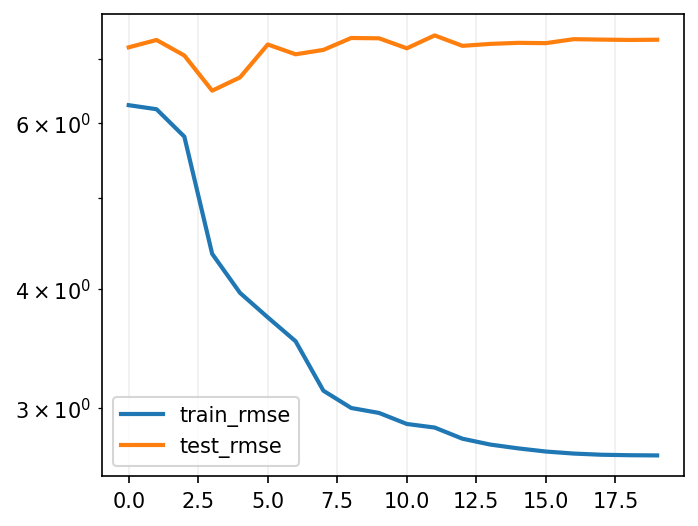

In [19]:
plt.figure(figsize=(5,4), dpi=150)
plt.plot(train_rmse, lw=2.0, label='train_rmse')
plt.plot(test_rmse, lw=2.0, label='test_rmse')
plt.yscale("log")
plt.grid("on", alpha=0.2)
plt.legend()
plt.show()

#### Save the model

In [20]:
load = False

# If load=True, specify the model to load in the below line
MODEL_PATH = "./model_weights/model_weights_test_run_2023-03-21_22:42:45.577525"

In [21]:
if load:
    model.load_state_dict(torch.load(MODEL_PATH))
else:
    MODEL_PATH='./model_weights/model_weights_{}'.format(wandb_run)
    torch.save(model.state_dict(), MODEL_PATH)

In [22]:
'''
Perform evaluation
'''
train_eval_dict = model.evaluate_batch(X_train.to(device), Y_train.to(device))
test_eval_dict = model.evaluate_batch(X_test.to(device), Y_test.to(device))

In [23]:
X_test.shape

torch.Size([473, 14, 15])

In [24]:
X_train.shape

torch.Size([722, 14, 15])

In [25]:
Y_train.shape

torch.Size([722, 14, 1])

In [26]:
Y_test.shape

torch.Size([473, 14, 1])

## 4. Plotting and Evaluation

In [27]:
'''
Create plot tables for T+n th predictions
'''
train_gt = train_eval_dict['y_true']
train_gt_df = pd.DataFrame(train_gt.cpu().numpy()[:,:,0])
train_gt_values = np.append(train_gt_df[0].values, train_gt_df.iloc[-1,1:]) # ground-truth values for train data

test_gt = test_eval_dict['y_true']
test_gt_df = pd.DataFrame(test_gt.cpu().numpy()[:,:,0])
test_gt_values = np.append(test_gt_df[0].values, test_gt_df.iloc[-1,1:]) # ground-truth values for test data

train_pred = train_eval_dict['y_pred'] # model predicted values for train data
test_pred = test_eval_dict['y_pred'] # model predicted values for test data

train_T_pred_table, train_plot_df, plot_train_gt_values = utils.predictionTable(df_train, train_pred, train_gt_values)

test_T_pred_table, test_plot_df, plot_test_gt_values = utils.predictionTable(df_test, test_pred, test_gt_values)

Index(['2018-08-28', '2018-08-29', '2018-08-30', '2018-08-31', '2018-09-01',
       '2018-09-02', '2018-09-03', '2018-09-04', '2018-09-05', '2018-09-06',
       ...
       '2020-07-27', '2020-07-28', '2020-07-29', '2020-07-30', '2020-07-31',
       '2020-08-01', '2020-08-02', '2020-08-03', '2020-08-04', '2020-08-05'],
      dtype='object', length=709)


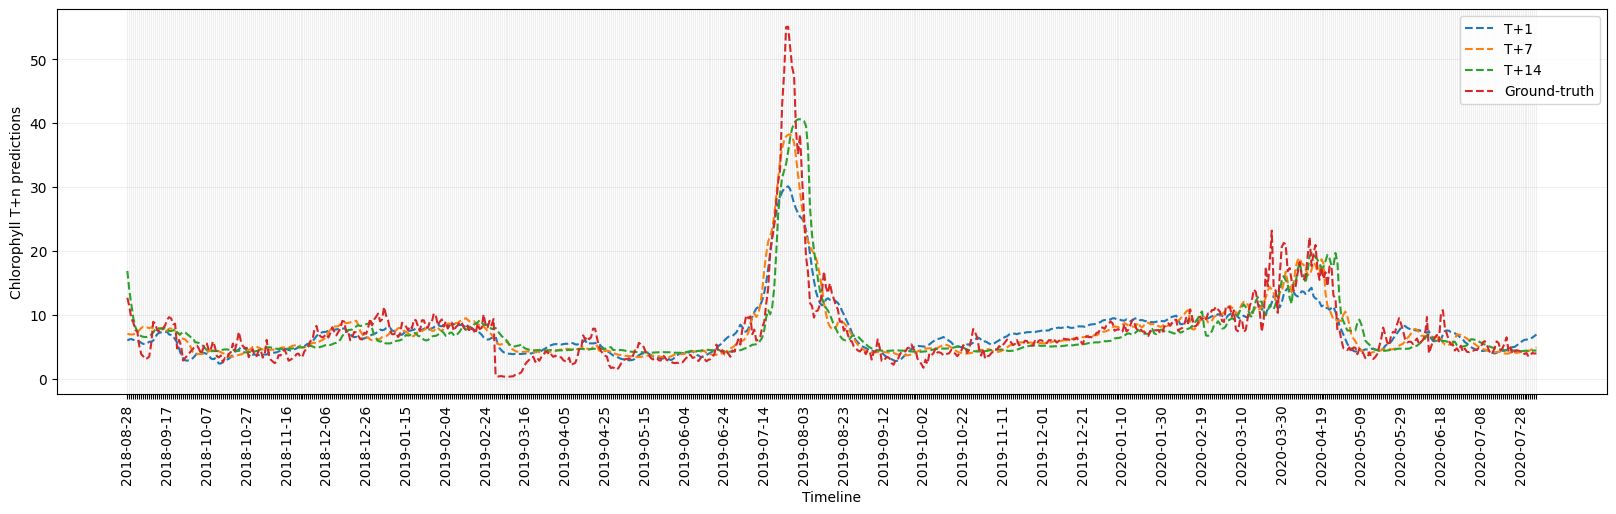

In [28]:
'''
Generate the plots on train data
'''

# Specify the list of T+n predictions to plot
horizon_range = [1,7, 14] # this will plot T+1 and T+n predictions w.r.t Ground truth

utils.plotTable(train_plot_df, plot_train_gt_values, horizon_range)

Index(['2020-09-15', '2020-09-16', '2020-09-17', '2020-09-18', '2020-09-19',
       '2020-09-20', '2020-09-21', '2020-09-22', '2020-09-23', '2020-09-24',
       ...
       '2021-12-09', '2021-12-10', '2021-12-11', '2021-12-12', '2021-12-13',
       '2021-12-14', '2021-12-15', '2021-12-16', '2021-12-17', '2021-12-18'],
      dtype='object', length=460)


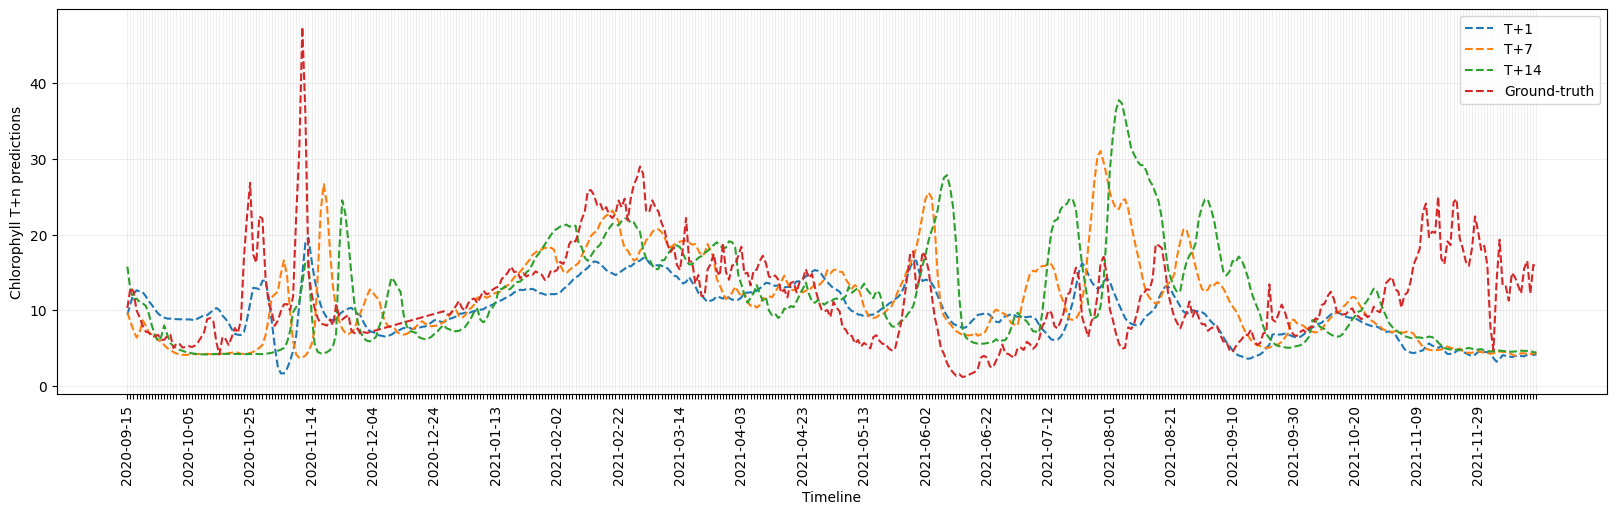

In [29]:
'''
Generate the plots on test data
'''

# Specify the list of T+n predictions to plot
horizon_range = [1,7,14] # this will plot T+1 and T+n predictions w.r.t Ground truth

utils.plotTable(test_plot_df, plot_test_gt_values, horizon_range)

In [30]:
test_plot_df

,2020-09-15,2020-09-16,2020-09-17,2020-09-18,2020-09-19,2020-09-20,2020-09-21,2020-09-22,2020-09-23,2020-09-24,...,2021-12-09,2021-12-10,2021-12-11,2021-12-12,2021-12-13,2021-12-14,2021-12-15,2021-12-16,2021-12-17,2021-12-18
1,9.381680,10.864429,12.171406,12.640646,12.487093,12.386169,11.853716,11.177465,10.697660,10.109581,...,3.923049,3.810735,3.949861,3.961510,3.948857,3.908047,4.115915,4.305667,4.089128,4.177321
2,8.435499,9.143663,10.062387,11.114979,11.470993,11.238796,11.095346,10.509724,9.787737,9.281061,...,4.033478,3.989344,3.899141,4.015909,4.028337,4.014096,3.980911,4.150712,4.307416,4.132368
3,6.927089,8.569260,8.886345,9.255795,9.975524,10.166744,9.852015,9.656477,9.055048,8.343280,...,4.133594,4.072073,4.036193,3.957750,4.061971,4.075377,4.059557,4.030442,4.178047,4.314569
4,6.395137,7.026539,8.652613,8.637741,8.548767,8.954914,8.981250,8.594698,8.348492,7.758390,...,3.856263,4.182176,4.126823,4.097066,4.028358,4.121311,4.134932,4.118614,4.092923,4.221933
5,7.371027,6.427072,7.074305,8.693489,8.401157,7.948409,8.086596,7.970739,7.538715,7.258167,...,3.794587,3.948053,4.233302,4.183416,4.158291,4.097688,4.180755,4.194074,4.177972,4.155183
6,8.486430,7.378405,6.424533,7.081153,8.698872,8.177399,7.449595,7.378094,7.156220,6.709810,...,4.099101,3.897928,4.031478,4.282710,4.237737,4.216223,4.162507,4.236850,4.249558,4.234104
7,9.722790,8.497590,7.353809,6.396166,7.056222,8.674542,7.966291,7.040877,6.818145,6.528306,...,4.432091,4.166340,3.989393,4.106444,4.328832,4.288282,4.269653,4.221860,4.288487,4.300416
8,10.565459,9.766119,8.478085,7.304103,6.348977,7.006993,8.625326,7.767234,6.708365,6.384991,...,4.511139,4.462976,4.226764,4.070349,4.173529,4.371184,4.334619,4.318340,4.275690,4.335477
9,10.884830,10.629519,9.780868,8.432848,7.235005,6.288525,6.939543,8.555315,7.579465,6.438255,...,4.542641,4.534570,4.491656,4.280950,4.142122,4.233497,4.409752,4.376770,4.362442,4.324285
10,11.064735,10.933601,10.667575,9.770127,8.366156,7.151271,6.219182,6.858802,8.468035,7.402189,...,4.594664,4.563470,4.556398,4.518025,4.329522,4.205894,4.287119,4.444720,4.414959,4.402276


In [31]:
train_plot_df

,2018-08-28,2018-08-29,2018-08-30,2018-08-31,2018-09-01,2018-09-02,2018-09-03,2018-09-04,2018-09-05,2018-09-06,...,2020-07-27,2020-07-28,2020-07-29,2020-07-30,2020-07-31,2020-08-01,2020-08-02,2020-08-03,2020-08-04,2020-08-05
1,6.009445,6.196495,6.241638,6.111172,6.009372,5.865625,5.863886,5.637627,5.477305,5.483009,...,5.468155,5.730062,5.943547,6.115178,6.152244,6.246058,6.303902,6.484612,6.720719,6.943739
2,6.338258,6.537596,6.750615,6.824008,6.716861,6.638693,6.517504,6.546643,6.341547,6.190211,...,4.868251,5.099436,5.355289,5.558825,5.724409,5.789380,5.920818,6.025459,6.255510,6.570775
3,6.522881,6.709671,6.928824,7.170958,7.269866,7.176560,7.113236,7.003681,7.058678,6.859444,...,4.486614,4.635351,4.847937,5.091430,5.281921,5.437917,5.517632,5.668887,5.800930,6.059032
4,6.676657,6.774458,6.976038,7.215240,7.486153,7.608476,7.524488,7.471839,7.369122,7.447039,...,4.327075,4.369119,4.498014,4.690022,4.915767,5.090515,5.234392,5.320392,5.479289,5.625288
5,6.801587,6.840063,6.942401,7.157813,7.416192,7.714806,7.858759,7.781075,7.736362,7.637441,...,4.180875,4.270802,4.310803,4.422601,4.594605,4.800976,4.959621,5.090823,5.177842,5.336694
6,6.935105,6.899317,6.937613,7.043975,7.271719,7.547752,7.872415,8.036304,7.962812,7.924087,...,4.210823,4.177564,4.252771,4.289948,4.387216,4.540750,4.727949,4.871202,4.990125,5.075008
7,7.067115,6.984318,6.945313,6.983499,7.093181,7.331414,7.623127,7.971700,8.153821,8.083035,...,4.120696,4.225290,4.194652,4.258244,4.292333,4.377309,4.514223,4.683336,4.812373,4.919850
8,7.310665,7.079504,6.992534,6.951083,6.989131,7.101316,7.347985,7.653083,8.023041,8.221634,...,4.131202,4.160639,4.251376,4.223361,4.277686,4.308698,4.383267,4.505413,4.657892,4.774036
9,7.814356,7.297905,7.059037,6.969084,6.925887,6.963704,7.077519,7.330464,7.646451,8.034963,...,4.185348,4.178755,4.204361,4.283605,4.258113,4.304951,4.333034,4.398757,4.507858,4.645247
10,8.353708,7.791278,7.257452,7.013347,6.921508,6.877192,6.914646,7.029207,7.286249,7.610519,...,4.267848,4.232704,4.226478,4.248897,4.318509,4.295384,4.336098,4.361464,4.419628,4.517228


#### Compute the RMSE values

In [32]:
'''
Compute train rmse

- Train RMSE values for all T+n th predictions. The index represents the T+n

'''
rmse_values = []
for i in range(output_window):
    rmse_values.append(utils.compute_rmse(i, train_T_pred_table, train_gt_values))
rmse_values = pd.DataFrame(rmse_values, columns=['RMSE'], index=range(1,output_window+1))
rmse_values

,RMSE
1,3.054484
2,2.831415
3,2.782340
4,2.741905
5,2.673911
6,2.593206
7,2.499485
8,2.433214
9,2.413053
10,2.416578


In [33]:
'''
Compute test rmse

- Test RMSE values for all T+n th predictions. The index represents the T+n

'''
test_rmse_values = []
for i in range(output_window):
    test_rmse_values.append(utils.compute_rmse(i, test_T_pred_table, test_gt_values))
test_rmse_values = pd.DataFrame(test_rmse_values, columns=['RMSE'], index=range(1,output_window+1))
test_rmse_values

,RMSE
1,5.973548
2,6.105809
3,6.332763
4,6.587464
5,6.836301
6,7.081212
7,7.325812
8,7.563852
9,7.777886
10,7.942930
